In [1]:
# Import required dependencies
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import math
import os
import sys

# Add the parent directory to sys.path
parent_dir = os.path.abspath("..")
sys.path.insert(0, parent_dir)

# Import custom modules
import simulator

# Configure matplotlib
plt.rcParams.update({
    "pgf.texsystem": "pdflatex",
    'font.family': 'serif',
    'text.usetex': True,
    'pgf.rcfonts': False,
})
plt.rcParams['axes.prop_cycle'] = plt.cycler(color=plt.cm.Set1(np.linspace(0, 1, 10)))

In [3]:
tp = 2
dp = 8 
bs = 16
device_num = 320

sequence_length = 4383
decode_length = 1210

args = simulator.ModelArgs()
gpu_list = simulator.get_gpu_info('../device/gpu_info.csv', decoding_mode=False)

gemm_group_per_device = math.ceil(args.n_routed_experts / device_num)

In [6]:
time_ms = simulator.prefill_time(
    args,
    gpu_list['H800'],
    sequence_length,
    kv_cache_rate=0.563,
    tp_num=tp,
    dp_num=dp,
)

print(f"Prefill time: {time_ms} ms")

Prefill time: 302.0553242764904 ms


In [15]:
time_ms, throughput = simulator.decode_time(
    args,
    gpu_list['H800'],
    tp_num=4,
    bs_num=64,
    seq_len=sequence_length,
    decode_len=decode_length,
    gemm_group_per_device=gemm_group_per_device,
    device_num=device_num,
    print_flag=False,
)

print(f"Decode time: {time_ms} ms")
print(f"Throughput: {throughput} tokens/s")

Decode time: 17.85995941107182 ms
Throughput: 3583.4347955082617 tokens/s


In [17]:
total_time_ms = 0
for current_decode_length in range(decode_length):
    time_ms, _ = simulator.decode_time(
        args,
        gpu_list['H800'],
        tp_num=tp,
        bs_num=bs,
        seq_len=sequence_length + current_decode_length,
        decode_len=current_decode_length,
        gemm_group_per_device=gemm_group_per_device,
        device_num=device_num,
        print_flag=False,
    )
    total_time_ms += time_ms

print(f"Decode time: {total_time_ms} ms")

Decode time: 15405.610756165308 ms


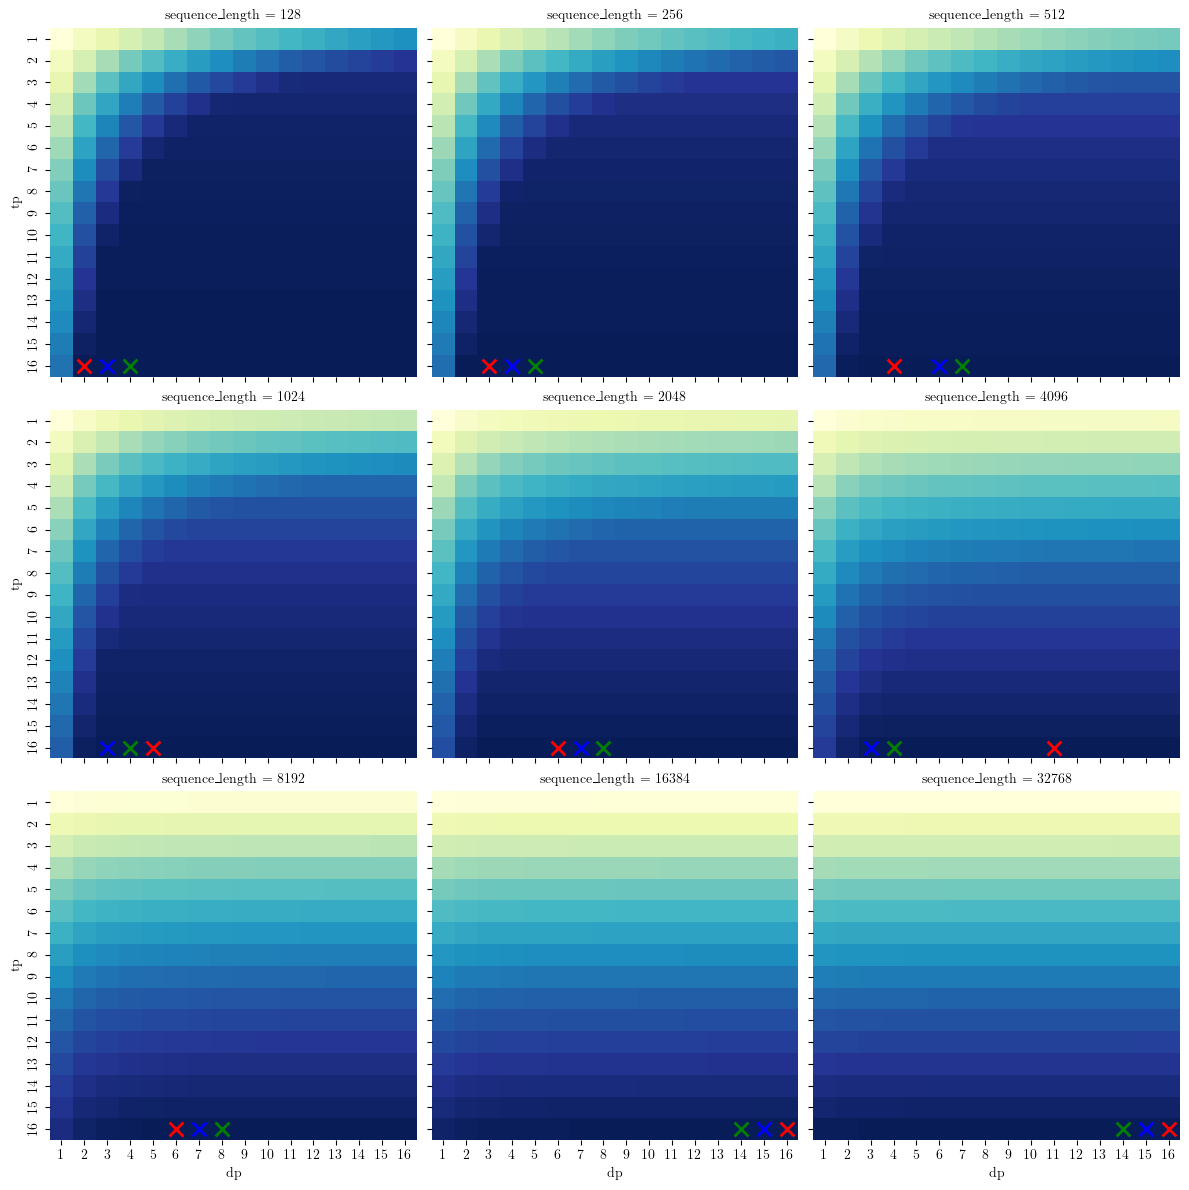

In [18]:
dp_list = list(range(1, 17))
tp_list = list(range(1, 17))
sequence_lengths = [128, 256, 512, 1024, 2048, 4096, 8192, 16384, 32768]

# collect results
results = []
for seq_len in sequence_lengths:
    for tp in tp_list:
        for dp in dp_list:
            time_ms = simulator.prefill_time(
                args,
                gpu_list['GB200-NVL72'],
                seq_len,
                kv_cache_rate=0.563,
                tp_num=tp,
                dp_num=dp,
            )
            throughput = seq_len * (1000.0 / time_ms)
            results.append({
                'tp': tp,
                'dp': dp,
                'sequence_length': seq_len,
                'throughput': throughput,
            })

df = pd.DataFrame(results)

# faceted heatmaps
g = sns.FacetGrid(
    df,
    col="sequence_length",
    col_wrap=3,
    height=4,
    sharex=True,
    sharey=True
)

def draw_heatmap(data, **kwargs):
    # pivot for this sequence length
    pivot = data.pivot(index="tp", columns="dp", values="throughput")
    ax = plt.gca()
    sns.heatmap(pivot, cbar=False, fmt=".1f", **kwargs)

    # find the top three tp/dp in this subset
    top_three = data.nlargest(3, 'throughput')
    
    # plot the best tp/dp
    best = top_three.iloc[0]
    best_tp, best_dp = int(best['tp']), int(best['dp'])
    row_idx = list(pivot.index).index(best_tp)
    col_idx = list(pivot.columns).index(best_dp)
    ax.scatter(
        col_idx + 0.5, 
        row_idx + 0.5, 
        marker='x', 
        color='red', 
        s=100, 
        linewidths=2
    )

    # plot the second best tp/dp
    second_best = top_three.iloc[1]
    second_best_tp, second_best_dp = int(second_best['tp']), int(second_best['dp'])
    row_idx = list(pivot.index).index(second_best_tp)
    col_idx = list(pivot.columns).index(second_best_dp)
    ax.scatter(
        col_idx + 0.5, 
        row_idx + 0.5, 
        marker='x', 
        color='blue', 
        s=100, 
        linewidths=2
    )

    # plot the third best tp/dp
    third_best = top_three.iloc[2]
    third_best_tp, third_best_dp = int(third_best['tp']), int(third_best['dp'])
    row_idx = list(pivot.index).index(third_best_tp)
    col_idx = list(pivot.columns).index(third_best_dp)
    ax.scatter(
        col_idx + 0.5, 
        row_idx + 0.5, 
        marker='x', 
        color='green', 
        s=100, 
        linewidths=2
    )

g.map_dataframe(draw_heatmap, cmap="YlGnBu")

for ax in g.axes.flat:
    ax.set_xlabel("dp")
    ax.set_ylabel("tp")

plt.show()